In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

**Load Preprocessed Data**





In [56]:
# Load datasets from local directory
movies_df = pd.read_csv("./CleanedData/movies_cleaned.csv") 
ratings_df = pd.read_csv("./CleanedData/ratings_cleaned.csv")

Cleaning and Processing List-Like Columns

In [59]:
# Function to safely convert string representation of lists into actual lists
def safe_eval(value):
    try:
        return ast.literal_eval(value) if isinstance(value, str) else value
    except:
        return []  # Return empty list if conversion fails

# Apply safe_eval to convert stringified lists into real lists
movies_df['genres'] = movies_df['genres'].apply(safe_eval)
movies_df['keywords'] = movies_df['keywords'].apply(safe_eval)
movies_df['cast'] = movies_df['cast'].apply(safe_eval)
movies_df['director'] = movies_df['director'].apply(safe_eval)

# Function to process genres, keywords, and directors into a single string
def process_metadata(value):
    return ' '.join(value) if isinstance(value, list) else ''

# Apply processing function
movies_df['genres'] = movies_df['genres'].apply(process_metadata)
movies_df['keywords'] = movies_df['keywords'].apply(process_metadata)
movies_df['director'] = movies_df['director'].apply(process_metadata)
movies_df['cast'] = movies_df['cast'].apply(lambda x: ' '.join(x[:3]) if isinstance(x, list) else '')

Creating "Metadata Soup" for Content-Based Filtering

In [65]:
movies_df['metadata_soup'] = (
    movies_df['genres'] + " " +
    movies_df['keywords'] + " " +
    movies_df['cast'] + " " +
    movies_df['director']
)

# Handle missing values
movies_df['metadata_soup'] = movies_df['metadata_soup'].fillna('')

# Display sample data
movies_df[['movieId', 'title', 'metadata_soup']].head()

,movieId,title,metadata_soup
0,862,Toy Story,"animation,comedy,family jealousy,toy,boy,frien..."
1,8844,Jumanji,"adventure,fantasy,family boardgame,disappearan..."
2,15602,Grumpier Old Men,"romance,comedy fishing,bestfriend,duringcredit..."
3,31357,Waiting To Exhale,"comedy,drama,romance basedonnovel,interracialr..."
4,11862,Father Of The Bride Part Ii,"comedy baby,midlifecrisis,confidence,aging,dau..."


TF-IDF Vectorizer (Convert text features into numerical vectors)

In [67]:
# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english')

# Convert metadata soup into a matrix
tfidf_matrix = tfidf.fit_transform(movies_df['metadata_soup'])

# Check the shape of the TF-IDF matrix
print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")


TF-IDF matrix shape: (21818, 43918)


Compute Cosine Similarity between Movies

In [70]:
# Compute the cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Check the shape of the similarity matrix
print(f"Cosine Similarity Matrix shape: {cosine_sim.shape}")

Cosine Similarity Matrix shape: (21818, 21818)


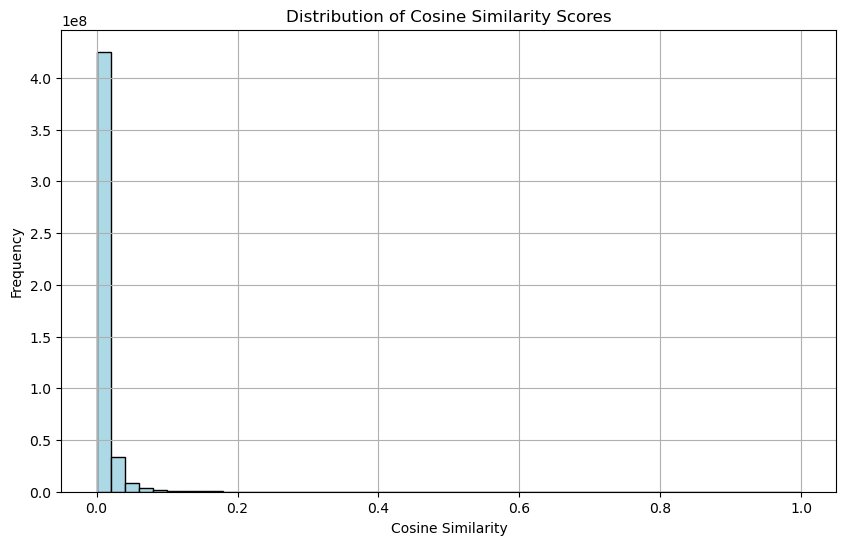

In [72]:
# Plot the distribution of cosine similarity scores
plt.figure(figsize=(10, 6))
plt.hist(cosine_sim.flatten(), bins=50, color='lightblue', edgecolor='black')
plt.title("Distribution of Cosine Similarity Scores")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


Recommendation function

In [74]:
# Create a mapping of movie titles to indices
indices = pd.Series(movies_df.index, index=movies_df['title'].str.lower().str.strip()).drop_duplicates()

def recommend_movies(title, num_recommendations=10):
    """Returns the top N recommended movies based on cosine similarity."""
    title = title.lower().strip()  # Convert to lowercase & remove extra spaces

    if title not in indices:
        print(f"Movie title '{title}' not found in dataset.")
        return pd.DataFrame(columns=['title', 'genres', 'release_year'])

    idx = indices[title]  # Get index of the movie
    sim_scores = list(enumerate(cosine_sim[idx].flatten()))  # Ensure similarity scores are 1D

    # Sort by similarity scores (excluding itself)
    sim_scores = sorted(sim_scores, key=lambda x: float(x[1]), reverse=True)[1:num_recommendations+1]

    # Extract valid movie indices
    movie_indices = [i[0] for i in sim_scores if i[0] < len(movies_df)]

    return movies_df.iloc[movie_indices][['title', 'genres', 'release_year']]

Testing Recommendation System

In [77]:
recommend_movies("Toy Story", 5)

,title,genres,release_year
13691,Toy Story That Time Forgot,"animation,family",2014
8852,Toy Story 3,"animation,family,comedy",2010
12015,Toy Story Of Terror,"animation,comedy,family",2013
2082,Toy Story 2,"animation,comedy,family",1999
2240,Creature Comforts,"animation,comedy,family",1989


In [79]:
recommend_movies("Transformers", 5)

,title,genres,release_year
8069,Transformers Revenge Of The Fallen,"sciencefiction,action,adventure",2009
21589,Transformers The Last Knight,"action,sciencefiction,thriller,adventure",2017
2560,The Transformers The Movie,animation,1986
12765,Transformers Age Of Extinction,"sciencefiction,action,adventure",2014
9712,Transformers Dark Of The Moon,"action,sciencefiction,adventure",2011


In [81]:
recommend_movies("Titanic", 5)

,title,genres,release_year
13564,Titanic,"action,drama,romance",1996


Evaluation Metrics

In [87]:
def evaluate_recommendations(test_movies, movies_df, cosine_sim, k_values=[5, 10, 15, 20]):
    """Evaluates the recommendation system using weighted precision and recall metrics."""
    precision_scores = []
    recall_scores = []

    for k in k_values:
        k_precision = []
        k_recall = []

        for movie in test_movies:
            recommendations = recommend_movies(movie, num_recommendations=k)[['title', 'genres']]
            
            # Get genres of the test movie
            genre_data = movies_df.loc[movies_df['title'].str.lower().str.strip() == movie.lower().strip(), 'genres']
            if genre_data.empty:
                continue  # Skip if movie not found
            
            true_genres = set(genre_data.values[0].split(','))  # Convert genres into a set

            # Calculate weighted relevance scores for recommended movies
            total_relevance_score = 0
            relevant_recommendations = 0

            for _, row in recommendations.iterrows():
                rec_genres = set(row['genres'].split(','))  # Convert recommended movie's genres into a set
                genre_overlap = len(true_genres & rec_genres) / len(true_genres)  # % of matching genres
                
                if genre_overlap > 0:
                    total_relevance_score += genre_overlap  # Sum relevance scores
                    relevant_recommendations += 1  # Count movies with some relevance

            # Compute weighted precision and recall
            precision = total_relevance_score / k if k > 0 else 0
            recall = total_relevance_score / len(true_genres) if len(true_genres) > 0 else 0

            k_precision.append(precision)
            k_recall.append(recall)

        # Store mean precision & recall for this k
        precision_scores.append(np.mean(k_precision))
        recall_scores.append(np.mean(k_recall))

    return k_values, precision_scores, recall_scores


Evaluation Results:
k=5: Precision=0.5070, Recall=1.2457
k=10: Precision=0.5095, Recall=2.5602
k=15: Precision=0.4997, Recall=3.7203
k=20: Precision=0.4778, Recall=4.6022


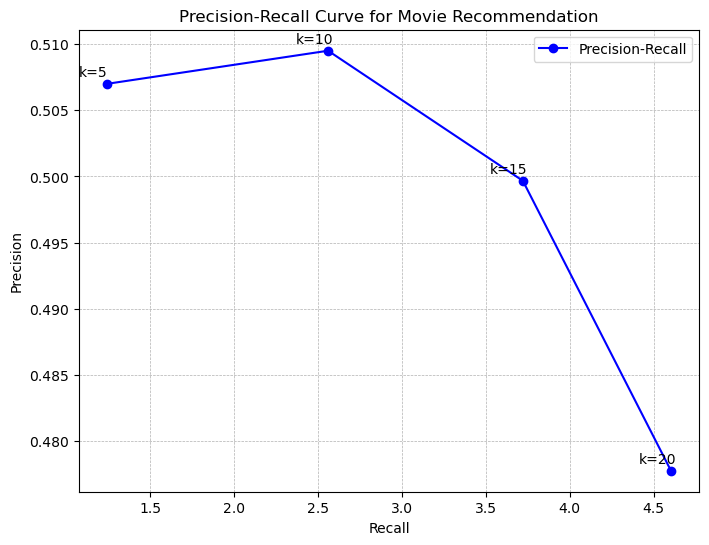

In [89]:
# Set a random seed for reproducibility
np.random.seed(42)

# Run Evaluation with multiple k values
test_movies = movies_df['title'].sample(10, random_state=42).tolist()
k_values, precision_scores, recall_scores = evaluate_recommendations(test_movies, movies_df, cosine_sim)

# Print the evaluation results
print("\nEvaluation Results:")
for k, precision, recall in zip(k_values, precision_scores, recall_scores):
    print(f"k={k}: Precision={precision:.4f}, Recall={recall:.4f}")

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall_scores, precision_scores, marker='o', linestyle='-', color='b', label="Precision-Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Movie Recommendation")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Annotate the points with k values
for i, k in enumerate(k_values):
    plt.annotate(f"k={k}", (recall_scores[i], precision_scores[i]), textcoords="offset points", xytext=(-10,5), ha='center')

plt.legend()
plt.show()

**Fine-Tuning**

Adjust TF-IDF Parameters

In [95]:
# Initialize TF-IDF Vectorizer with tuned hyperparameters
tfidf = TfidfVectorizer(stop_words='english', max_df=0.8, min_df=2)

# Fit and transform the metadata_soup (instead of content_features)
tfidf_matrix = tfidf.fit_transform(movies_df['metadata_soup'])

# Compute the cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Check the shape of the matrices
print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")
print(f"Cosine Similarity Matrix shape: {cosine_sim.shape}")


TF-IDF matrix shape: (21818, 17635)
Cosine Similarity Matrix shape: (21818, 21818)



Updated Evaluation Results After TF-IDF Tuning:
k=5: Precision=0.5370, Recall=1.3707
k=10: Precision=0.5510, Recall=2.7920
k=15: Precision=0.5403, Recall=4.1498
k=20: Precision=0.5360, Recall=5.5665


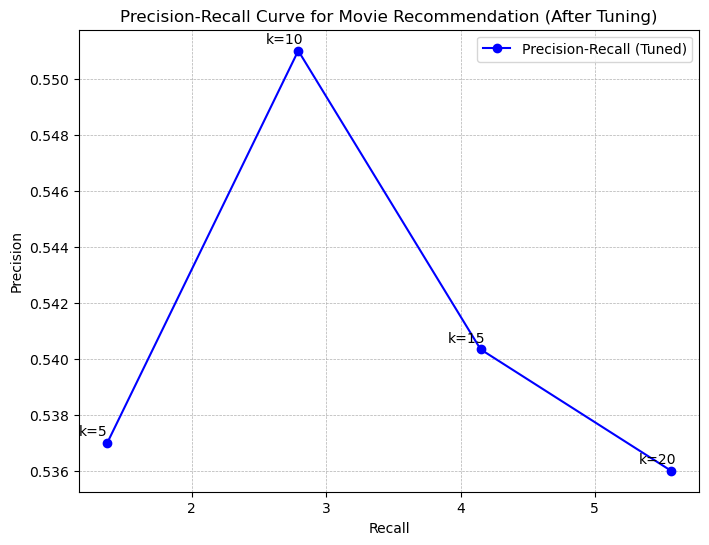

In [97]:
# Set a random seed for reproducibility
np.random.seed(42)

# Select 10 random test movies
test_movies = movies_df['title'].sample(10, random_state=42).tolist()

# Run evaluation with multiple k values
k_values, precision_scores, recall_scores = evaluate_recommendations(test_movies, movies_df, cosine_sim)

# Print the updated evaluation results
print("\nUpdated Evaluation Results After TF-IDF Tuning:")
for k, precision, recall in zip(k_values, precision_scores, recall_scores):
    print(f"k={k}: Precision={precision:.4f}, Recall={recall:.4f}")

# Plot the new Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall_scores, precision_scores, marker='o', linestyle='-', color='b', label="Precision-Recall (Tuned)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Movie Recommendation (After Tuning)")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Annotate the points with k values
for i, k in enumerate(k_values):
    plt.annotate(f"k={k}", (recall_scores[i], precision_scores[i]), textcoords="offset points", xytext=(-10,5), ha='center')

plt.legend()
plt.show()

In [99]:
import os
import joblib
import pickle

local_dir = "./Pickle"
os.makedirs(local_dir, exist_ok=True)

# Save the cosine similarity matrix
with open(f"{local_dir}/cosine_sim.pkl", 'wb') as f:
    pickle.dump(cosine_sim, f)

# Save the movie indices mapping
with open(f"{local_dir}/indices.pkl", 'wb') as f:
    pickle.dump(indices, f)

print("✅ Saved cosine similarity matrix and indices for deployment!")

✅ Saved cosine similarity matrix and indices for deployment!
